In [42]:
import os
import sys
os.environ["JAVA_HOME"] = "/Users/jedrzej/Library/Java/JavaVirtualMachines/openjdk-23.0.2/Contents/Home"
os.environ["JDK_JAVA_OPTIONS"] = "-Djava.security.manager=allow"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [43]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, avg, hour, floor
from pyspark.sql.functions import to_date, month, dayofmonth, lit, concat_ws
from pyspark.sql import Window
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import IntegerType, DoubleType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np

In [44]:
spark = SparkSession.builder \
    .appName("ImprovedFlightDelayPrediction") \
    .config("spark.driver.memory", "12g") \
    .config("spark.driver.maxResultSize", "4g") \
    .master("local[*]") \
    .getOrCreate()

df = spark.read.csv("Flight_delay.csv", header=True, inferSchema=True)
print(f"Original row count: {df.count()}")
df.printSchema()

Original row count: 484551
root
 |-- DayOfWeek: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- Airline: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Org_Airport: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Dest_Airport: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverte

In [45]:
df_clean = df.filter((col("Cancelled") == 0) & (col("Diverted") == 0)) \
             .drop("Cancelled", "Diverted") \
             .withColumn("ArrDelay", col("ArrDelay").cast("double")) \
             .withColumn("DepDelay", col("DepDelay").cast("double"))

df_clean = df_clean.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))
df_clean = df_clean.withColumn("Month", month(col("Date")))
df_clean = df_clean.withColumn("Day", dayofmonth(col("Date")))
df_clean = df_clean.withColumn("DepHour", (col("DepTime") / 100).cast("int"))
df_clean = df_clean.withColumn("ArrHour", (col("ArrTime") / 100).cast("int"))
df_clean = df_clean.withColumn("IsWeekend", when(col("DayOfWeek").isin([6, 7]), 1).otherwise(0))

df_clean = df_clean.withColumn("TaxiTotal", col("TaxiIn") + col("TaxiOut"))
df_clean = df_clean.withColumn("ScheduledFlightTime", col("CRSElapsedTime"))
df_clean = df_clean.withColumn("ActualFlightTime", col("ActualElapsedTime"))
df_clean = df_clean.withColumn("FlightTimeDiff", col("ActualElapsedTime") - col("CRSElapsedTime"))
df_clean = df_clean.withColumn("CRSArrHour", floor(col("CRSArrTime") / 100))
df_clean = df_clean.dropna(subset=["ArrDelay", "DepDelay", "UniqueCarrier", "Origin", "Dest"])
print(f"Row count after cleaning: {df_clean.count()}")

Row count after cleaning: 484551


In [46]:
df_clean = df_clean.withColumn("TimeOfDay",
    when(col("DepHour").between(6, 11), "Morning")
    .when(col("DepHour").between(12, 17), "Afternoon")
    .when(col("DepHour").between(18, 21), "Evening")
    .otherwise("Night")
)

df_clean = df_clean.withColumn("DistanceCategory",
    when(col("Distance") < 500, "Short")
    .when(col("Distance").between(500, 1500), "Medium")
    .otherwise("Long")
)

df_clean = df_clean.withColumn("Route",
    concat_ws("-", col("Origin"), col("Dest"))
)

carrier_stats = df_clean.groupBy("UniqueCarrier").agg(
    avg("ArrDelay").alias("AvgCarrierDelay"),
    count("*").alias("CarrierFlightCount")
)
df_clean = df_clean.join(carrier_stats, "UniqueCarrier", "left")

hour_stats = df_clean.groupBy("DepHour").agg(
    avg("ArrDelay").alias("AvgHourDelay")
)
df_clean = df_clean.join(hour_stats, "DepHour", "left")

route_stats = df_clean.groupBy("Route").agg(
    avg("ArrDelay").alias("AvgRouteDelay"),
    count("*").alias("RouteFlightCount")
)
df_clean = df_clean.join(route_stats, "Route", "left")

origin_stats = df_clean.groupBy("Origin").agg(
    avg("ArrDelay").alias("AvgOriginDelay")
)
df_clean = df_clean.join(origin_stats, "Origin", "left")

dest_stats = df_clean.groupBy("Dest").agg(
    avg("ArrDelay").alias("AvgDestDelay")
)
df_clean = df_clean.join(dest_stats, "Dest", "left")

carrier_hour_stats = df_clean.groupBy("UniqueCarrier", "DepHour").agg(
    avg("ArrDelay").alias("AvgCarrierHourDelay")
)
df_clean = df_clean.join(carrier_hour_stats, ["UniqueCarrier", "DepHour"], "left")

df_clean = df_clean.withColumn("IsRushHour",
    when((col("DepHour").between(6, 9)) | (col("DepHour").between(17, 20)), 1)
    .otherwise(0)
)

In [47]:
agg_cols = ["AvgCarrierDelay", "AvgHourDelay", "AvgRouteDelay",
            "AvgOriginDelay", "AvgDestDelay", "AvgCarrierHourDelay"]
for col_name in agg_cols:
    df_clean = df_clean.withColumn(col_name,
        when(col(col_name).isNull(), 0).otherwise(col(col_name))
    )

### FEATURES

In [48]:
numeric_features_no_dep = [
    'DayOfWeek', 'Month', 'Day', 'DepHour', 'IsWeekend', 'IsRushHour',
    'Distance', 'CRSElapsedTime', 'CRSArrHour',
    'AvgCarrierDelay', 'AvgHourDelay', 'AvgRouteDelay',
    'AvgOriginDelay', 'AvgDestDelay', 'AvgCarrierHourDelay',
    'CarrierFlightCount', 'RouteFlightCount'
]


In [49]:
numeric_features_with_dep = numeric_features_no_dep + [
    'DepDelay', 'TaxiOut'
]

In [50]:
categorical_features = ['UniqueCarrier', 'Origin', 'Dest', 'TimeOfDay', 'DistanceCategory']
TARGET = 'ArrDelay'

### Pipelines

In [51]:
def create_pipeline(numeric_features, use_standard_scaler=False):
    stages = []

    for cat_col in categorical_features:
        indexer = StringIndexer(inputCol=cat_col, outputCol=f"{cat_col}Index", handleInvalid="keep")
        encoder = OneHotEncoder(inputCol=f"{cat_col}Index", outputCol=f"{cat_col}Vec")
        stages.extend([indexer, encoder])

    assembler_inputs = [f"{c}Vec" for c in categorical_features] + numeric_features
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features_raw")
    stages.append(assembler)

    if use_standard_scaler:
        scaler = StandardScaler(inputCol="features_raw", outputCol="features")
    else:
        scaler = MinMaxScaler(inputCol="features_raw", outputCol="features")
    stages.append(scaler)

    return stages

### Data split

In [52]:
all_features = list(set(numeric_features_with_dep + categorical_features + [TARGET]))
df_model = df_clean.select(all_features)

In [53]:
train_data, test_data = df_model.randomSplit([0.8, 0.2], seed=42)
print(f"\nTraining set size: {train_data.count()}")
print(f"Testing set size: {test_data.count()}")


Training set size: 387868


Testing set size: 96683


### Models

In [54]:
models = {
    "Linear Regression": LinearRegression(featuresCol="features", labelCol=TARGET, maxIter=100),
    "Random Forest": RandomForestRegressor(featuresCol="features", labelCol=TARGET,
                                           numTrees=20, maxDepth=10, seed=42),
    "GBT Regressor": GBTRegressor(featuresCol="features", labelCol=TARGET,
                                  maxIter=100, maxDepth=7, seed=42)
}

In [55]:
evaluator_rmse = RegressionEvaluator(labelCol=TARGET, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=TARGET, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=TARGET, predictionCol="prediction", metricName="r2")

In [56]:
results_a = []
best_model_a = None
best_r2_a = -float('inf')
best_model_name_a = ""
best_predictions_a = None

In [57]:
results_b = []
best_model_b = None
best_r2_b = -float('inf')
best_model_name_b = ""
best_predictions_b = None

In [58]:
pipeline_stages_a = create_pipeline(numeric_features_no_dep, use_standard_scaler=False)
pipeline_stages_b = create_pipeline(numeric_features_with_dep, use_standard_scaler=False)

#### Model A

In [59]:
for name, model in models.items():
    print(f"\nTraining {name}...")

    model_pipeline = Pipeline(stages=pipeline_stages_a + [model])
    model_fit = model_pipeline.fit(train_data)
    predictions = model_fit.transform(test_data)

    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)

    print(f"{name} Results:")
    print(f"RMSE:{rmse:.4f}")
    print(f"MAE:{mae:.4f}")
    print(f"R2:{r2:.4f}")

    results_a.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

    if r2 > best_r2_a:
        best_r2_a = r2
        best_model_a = model_fit
        best_model_name_a = name
        best_predictions_a = predictions

print(f"Best Model A: {best_model_name_a} with R2: {best_r2_a:.4f}")


Training Linear Regression...


25/12/03 18:06:11 WARN Instrumentation: [e86b3dbd] regParam is zero, which might cause numerical instability and overfitting.
25/12/03 18:06:13 WARN Instrumentation: [e86b3dbd] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Linear Regression Results:
RMSE:53.1077
MAE:34.1863
R2:0.1542

Training Random Forest...


25/12/03 18:07:11 WARN DAGScheduler: Broadcasting large task binary with size 1290.6 KiB
25/12/03 18:07:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/12/03 18:07:37 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/12/03 18:07:55 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
25/12/03 18:08:16 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
25/12/03 18:08:36 WARN DAGScheduler: Broadcasting large task binary with size 1041.5 KiB
25/12/03 18:08:37 WARN DAGScheduler: Broadcasting large task binary with size 21.2 MiB
25/12/03 18:09:00 WARN DAGScheduler: Broadcasting large task binary with size 1874.3 KiB
25/12/03 18:09:02 WARN DAGScheduler: Broadcasting large task binary with size 25.5 MiB
25/12/03 18:09:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 18:09:21 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
25/12/03 18:09:28 WARN DAGScheduler: Broa

Random Forest Results:
RMSE:41.3353
MAE:28.0430
R2:0.4876

Training GBT Regressor...


25/12/03 18:10:35 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB
25/12/03 18:10:35 WARN DAGScheduler: Broadcasting large task binary with size 1003.1 KiB
25/12/03 18:10:35 WARN DAGScheduler: Broadcasting large task binary with size 1003.7 KiB
25/12/03 18:10:36 WARN DAGScheduler: Broadcasting large task binary with size 1004.9 KiB
25/12/03 18:10:36 WARN DAGScheduler: Broadcasting large task binary with size 1007.2 KiB
25/12/03 18:10:36 WARN DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
25/12/03 18:10:36 WARN DAGScheduler: Broadcasting large task binary with size 1020.8 KiB
25/12/03 18:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1023.3 KiB
25/12/03 18:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1023.7 KiB
25/12/03 18:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1024.3 KiB
25/12/03 18:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1025.5 KiB
25/12/03 18:10:37 WAR

GBT Regressor Results:
RMSE:31.2267
MAE:21.0405
R2:0.7076
Best Model A: GBT Regressor with R2: 0.7076


In [60]:
for name, model in models.items():
    print(f"\nTraining {name}...")

    model_pipeline = Pipeline(stages=pipeline_stages_b + [model])
    model_fit = model_pipeline.fit(train_data)
    predictions = model_fit.transform(test_data)

    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)

    print(f"{name} Results:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R2:   {r2:.4f}")

    results_b.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

    if r2 > best_r2_b:
        best_r2_b = r2
        best_model_b = model_fit
        best_model_name_b = name
        best_predictions_b = predictions

print(f"Best Model B: {best_model_name_b} with R2: {best_r2_b:.4f}")


Training Linear Regression...


25/12/03 18:13:08 WARN Instrumentation: [33098a97] regParam is zero, which might cause numerical instability and overfitting.
25/12/03 18:13:10 WARN Instrumentation: [33098a97] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Linear Regression Results:
  RMSE: 10.7155
  MAE:  7.4514
  R2:   0.9656

Training Random Forest...


25/12/03 18:14:00 WARN DAGScheduler: Broadcasting large task binary with size 1299.8 KiB
25/12/03 18:14:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/12/03 18:14:26 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/12/03 18:14:42 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
25/12/03 18:15:01 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
25/12/03 18:15:22 WARN DAGScheduler: Broadcasting large task binary with size 1040.2 KiB
25/12/03 18:15:23 WARN DAGScheduler: Broadcasting large task binary with size 21.3 MiB
25/12/03 18:15:48 WARN DAGScheduler: Broadcasting large task binary with size 1867.9 KiB
25/12/03 18:15:50 WARN DAGScheduler: Broadcasting large task binary with size 24.5 MiB
25/12/03 18:16:08 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/12/03 18:16:09 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
25/12/03 18:16:17 WARN DAGScheduler: Broa

Random Forest Results:
  RMSE: 18.4836
  MAE:  10.2854
  R2:   0.8975

Training GBT Regressor...


25/12/03 18:17:25 WARN DAGScheduler: Broadcasting large task binary with size 1003.3 KiB
25/12/03 18:17:25 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB
25/12/03 18:17:25 WARN DAGScheduler: Broadcasting large task binary with size 1016.2 KiB
25/12/03 18:17:26 WARN DAGScheduler: Broadcasting large task binary with size 1016.7 KiB
25/12/03 18:17:26 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
25/12/03 18:17:26 WARN DAGScheduler: Broadcasting large task binary with size 1018.4 KiB
25/12/03 18:17:26 WARN DAGScheduler: Broadcasting large task binary with size 1020.5 KiB
25/12/03 18:17:26 WARN DAGScheduler: Broadcasting large task binary with size 1024.6 KiB
25/12/03 18:17:27 WARN DAGScheduler: Broadcasting large task binary with size 1032.1 KiB
25/12/03 18:17:27 WARN DAGScheduler: Broadcasting large task binary with size 1034.6 KiB
25/12/03 18:17:27 WARN DAGScheduler: Broadcasting large task binary with size 1035.0 KiB
25/12/03 18:17:27 WAR

GBT Regressor Results:
  RMSE: 14.7019
  MAE:  8.3889
  R2:   0.9352
Best Model B: Linear Regression with R2: 0.9656


### Model comparasing

In [61]:
results_df_a = pd.DataFrame(results_a)
results_df_a['Type'] = 'Model A (bez DepDelay)'

results_df_b = pd.DataFrame(results_b)
results_df_b['Type'] = 'Model B (z DepDelay)'

results_combined = pd.concat([results_df_a, results_df_b])

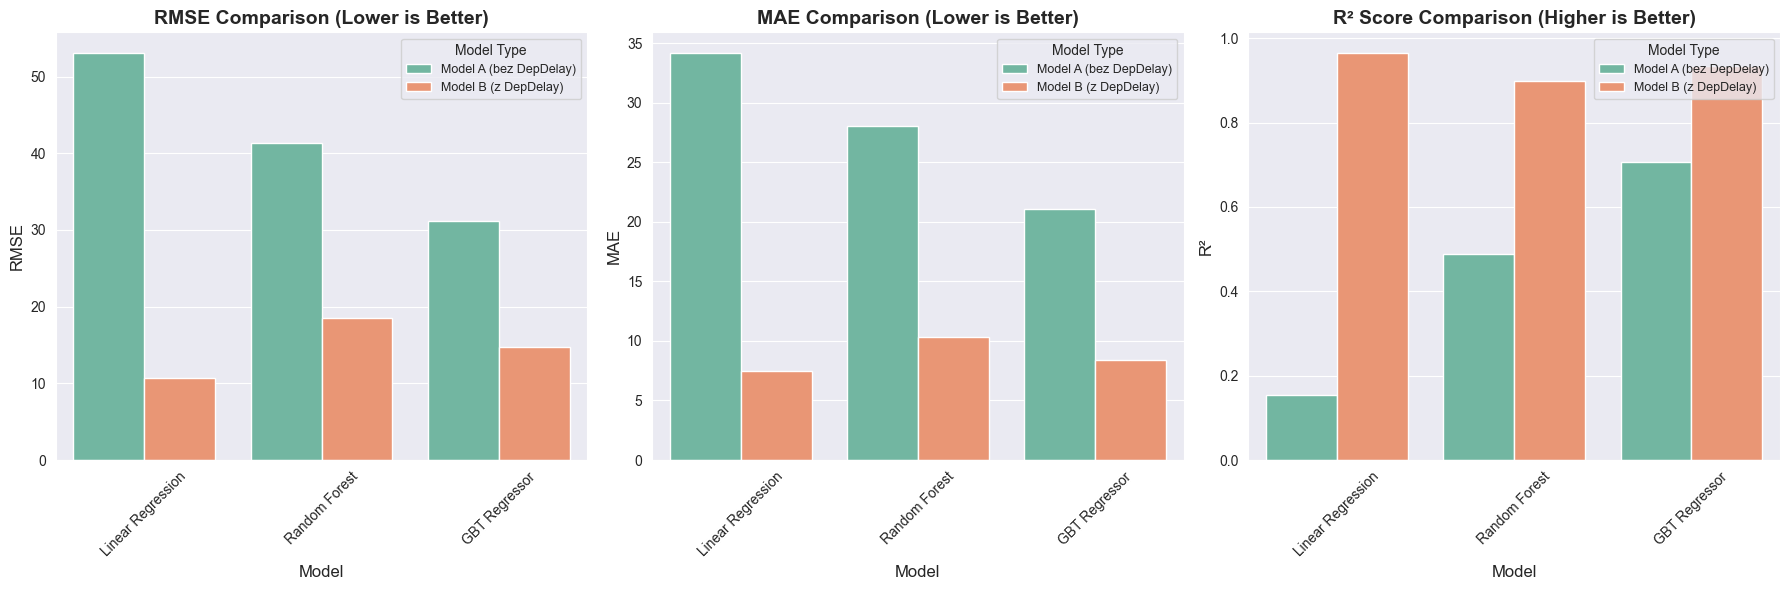

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE
sns.barplot(data=results_combined, x="Model", y="RMSE", hue="Type", ax=axes[0], palette="Set2")
axes[0].set_title("RMSE Comparison (Lower is Better)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Model", fontsize=12)
axes[0].set_ylabel("RMSE", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Model Type', fontsize=9)

# MAE
sns.barplot(data=results_combined, x="Model", y="MAE", hue="Type", ax=axes[1], palette="Set2")
axes[1].set_title("MAE Comparison (Lower is Better)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Model", fontsize=12)
axes[1].set_ylabel("MAE", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Model Type', fontsize=9)

# R2
sns.barplot(data=results_combined, x="Model", y="R2", hue="Type", ax=axes[2], palette="Set2")
axes[2].set_title("R² Score Comparison (Higher is Better)", fontsize=14, fontweight='bold')
axes[2].set_xlabel("Model", fontsize=12)
axes[2].set_ylabel("R²", fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(title='Model Type', fontsize=9)

plt.tight_layout()
plt.show()

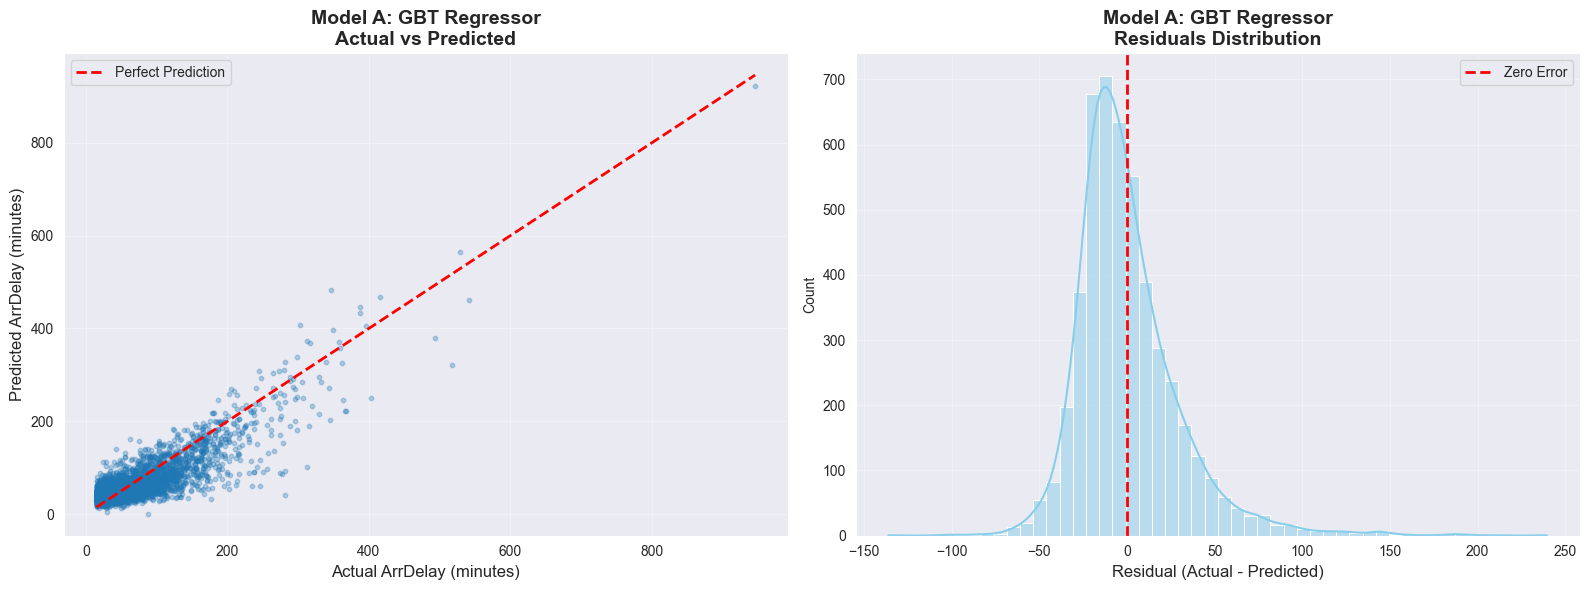

In [63]:
sample_preds_a = best_predictions_a.select(TARGET, "prediction").sample(False, 0.05, seed=42).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted
axes[0].scatter(sample_preds_a[TARGET], sample_preds_a["prediction"], alpha=0.3, s=10)
axes[0].plot([sample_preds_a[TARGET].min(), sample_preds_a[TARGET].max()],
             [sample_preds_a[TARGET].min(), sample_preds_a[TARGET].max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel("Actual ArrDelay (minutes)", fontsize=12)
axes[0].set_ylabel("Predicted ArrDelay (minutes)", fontsize=12)
axes[0].set_title(f"Model A: {best_model_name_a}\nActual vs Predicted", fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals
sample_preds_a["Residuals"] = sample_preds_a[TARGET] - sample_preds_a["prediction"]
sns.histplot(sample_preds_a["Residuals"], kde=True, bins=50, ax=axes[1], color='skyblue')
axes[1].set_title(f"Model A: {best_model_name_a}\nResiduals Distribution", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Residual (Actual - Predicted)", fontsize=12)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

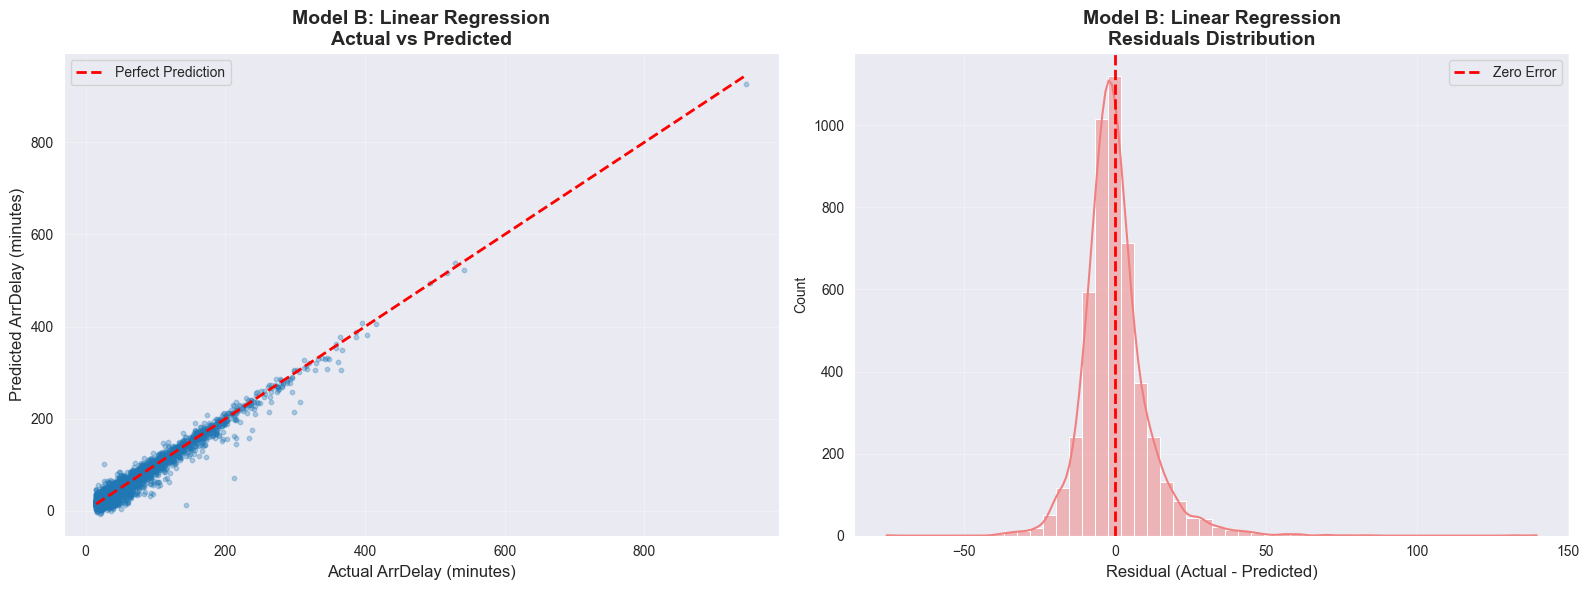

In [64]:
sample_preds_b = best_predictions_b.select(TARGET, "prediction").sample(False, 0.05, seed=42).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted
axes[0].scatter(sample_preds_b[TARGET], sample_preds_b["prediction"], alpha=0.3, s=10)
axes[0].plot([sample_preds_b[TARGET].min(), sample_preds_b[TARGET].max()],
             [sample_preds_b[TARGET].min(), sample_preds_b[TARGET].max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel("Actual ArrDelay (minutes)", fontsize=12)
axes[0].set_ylabel("Predicted ArrDelay (minutes)", fontsize=12)
axes[0].set_title(f"Model B: {best_model_name_b}\nActual vs Predicted", fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals
sample_preds_b["Residuals"] = sample_preds_b[TARGET] - sample_preds_b["prediction"]
sns.histplot(sample_preds_b["Residuals"], kde=True, bins=50, ax=axes[1], color='lightcoral')
axes[1].set_title(f"Model B: {best_model_name_b}\nResiduals Distribution", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Residual (Actual - Predicted)", fontsize=12)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Feature Importance

In [65]:
if "Random Forest" in best_model_name_a:
    rf_model = best_model_a.stages[-1]
    feature_names = [f"{c}Vec" for c in categorical_features] + numeric_features_no_dep

    importances = rf_model.featureImportances.toArray()
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
    plt.title(f'Top 20 Feature Importance - {best_model_name_a} (Model A)',
              fontsize=14, fontweight='bold')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\nTop 10 najważniejszych cech:")
    print(feature_importance_df.head(10).to_string(index=False))

### Cross Validation

In [66]:
rf = RandomForestRegressor(featuresCol="features", labelCol=TARGET, seed=42)
pipeline = Pipeline(stages=pipeline_stages_a + [rf])

model_baseline = pipeline.fit(train_data)
preds_baseline = model_baseline.transform(test_data)

evaluator = RegressionEvaluator(labelCol=TARGET, predictionCol="prediction", metricName="rmse")
rmse_baseline = evaluator.evaluate(preds_baseline)
print(f"   -> RMSE Baseline: {rmse_baseline:.4f}")

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train_data)

   -> RMSE Baseline: 51.1000


25/12/03 18:21:16 WARN DAGScheduler: Broadcasting large task binary with size 1136.3 KiB
25/12/03 18:21:20 WARN DAGScheduler: Broadcasting large task binary with size 1734.2 KiB
25/12/03 18:21:25 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/12/03 18:21:36 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
25/12/03 18:21:49 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
25/12/03 18:22:32 WARN DAGScheduler: Broadcasting large task binary with size 1317.7 KiB
25/12/03 18:22:58 WARN DAGScheduler: Broadcasting large task binary with size 1317.7 KiB
25/12/03 18:23:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/12/03 18:23:10 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/12/03 18:23:19 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
25/12/03 18:23:37 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
25/12/03 18:24:09 WARN DAGScheduler: Broa

In [67]:
best_model = cvModel.bestModel
best_rf = best_model.stages[-1]

preds_tuned = best_model.transform(test_data)
rmse_tuned = evaluator.evaluate(preds_tuned)

print(f"\n3. Wyniki strojenia:")
print(f"   -> RMSE Tuned:    {rmse_tuned:.4f}")
print(f"   -> POPRAWA O:     {rmse_baseline - rmse_tuned:.4f} ({(1 - rmse_tuned/rmse_baseline)*100:.2f}%)")

print("\nNAJLEPSZE PARAMETRY:")
print(f"   - Liczba drzew (NumTrees): {best_rf.getNumTrees}")
print(f"   - Głębokość (MaxDepth):    {best_rf.getOrDefault('maxDepth')}")


3. Wyniki strojenia:
   -> RMSE Tuned:    40.6351
   -> POPRAWA O:     10.4649 (20.48%)

NAJLEPSZE PARAMETRY:
   - Liczba drzew (NumTrees): 20
   - Głębokość (MaxDepth):    10


/var/folders/dk/jww3fh693dg2b9_ksjhpzs400000gn/T/ipykernel_9270/1691087015.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='RMSE', data=results_df, palette=['gray', '#10b981'])


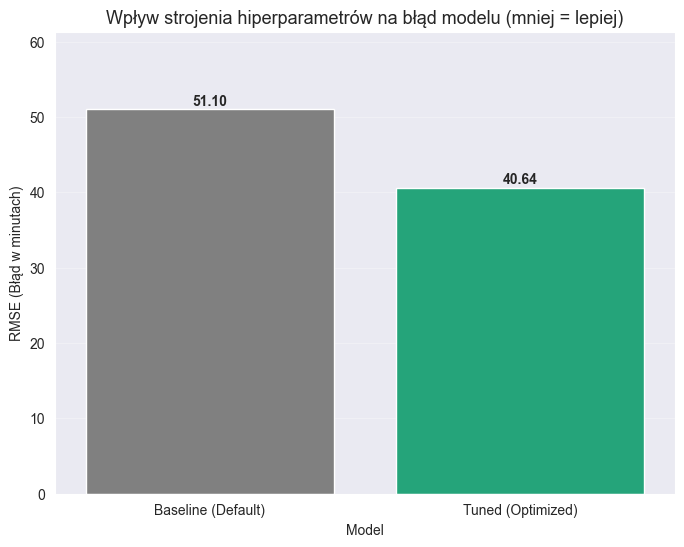

In [68]:
results_df = pd.DataFrame({
    'Model': ['Baseline (Default)', 'Tuned (Optimized)'],
    'RMSE': [rmse_baseline, rmse_tuned]
})

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Model', y='RMSE', data=results_df, palette=['gray', '#10b981'])

for i, v in enumerate(results_df['RMSE']):
    ax.text(i, v + 0.5, f"{v:.2f}", ha='center', fontweight='bold')

plt.title('Wpływ strojenia hiperparametrów na błąd modelu (mniej = lepiej)', fontsize=13)
plt.ylabel('RMSE (Błąd w minutach)')
plt.ylim(0, max(rmse_baseline, rmse_tuned) * 1.2)
plt.grid(axis='y', alpha=0.3)
plt.show()

### Save results

In [69]:
if best_model_a is not None:
    try:
        best_model_a.write().overwrite().save("model_a_gbt")
        print("Model A saved to: model_a_gbt/")
    except Exception as e:
        print(f"Error saving Model A: {e}")


if best_model_b is not None:
    try:
        best_model_b.write().overwrite().save("model_b_lr")
        print("Model B saved to: model_b_lr/")
    except Exception as e:
        print(f"Error saving Model B: {e}")

Model A saved to: model_a_gbt/
Model B saved to: model_b_lr/


In [70]:
stats_to_save = {
    'carrier_stats': carrier_stats.toPandas().set_index('UniqueCarrier')['AvgCarrierDelay'].to_dict(),
    'hour_stats': hour_stats.toPandas().set_index('DepHour')['AvgHourDelay'].to_dict(),
    'route_stats': route_stats.toPandas().set_index('Route')['AvgRouteDelay'].to_dict(),
    'origin_stats': origin_stats.toPandas().set_index('Origin')['AvgOriginDelay'].to_dict(),
    'dest_stats': dest_stats.toPandas().set_index('Dest')['AvgDestDelay'].to_dict(),
}

In [71]:
carrier_hour_dict = {}
try:
    for row in carrier_hour_stats.toPandas().itertuples():
        key = f"{row.UniqueCarrier}_{row.DepHour}"
        carrier_hour_dict[key] = row.AvgCarrierHourDelay
    stats_to_save['carrier_hour_stats'] = carrier_hour_dict
except Exception as e:
    print(f"Błąd przy przetwarzaniu carrier_hour_stats: {e}")

In [72]:
try:
    routes_df = df.select("Origin", "Dest", "Distance").dropna().distinct()

    route_distances = {}
    rows = routes_df.collect()

    for row in rows:
        key = f"{row.Origin}-{row.Dest}"
        route_distances[key] = int(row.Distance)

    stats_to_save['route_distances'] = route_distances
    print(f"Zapisano mapę odległości ({len(route_distances)} tras).")
except Exception as e:
    print(f"Błąd przy generowaniu mapy tras: {e}")
    stats_to_save['route_distances'] = {}

Zapisano mapę odległości (3377 tras).


In [73]:
with open('aggregated_stats.pkl', 'wb') as f:
    pickle.dump(stats_to_save, f)

In [74]:
spark.stop()